# History

**2021-11-05:**
  - Initial version. New competition.

# Purpose

- TODO: Update purpose.
- This notebook is used to identify the important features.

# TODO

https://www.kaggle.com/sz8416/6-ways-for-feature-selection

In [1]:
import pandas as pd
import os
import configparser
import numpy as np
import gc
import tensorflow as tf
import urllib, requests #for Telegram notifications
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Checking GPU support
print(tf.test.is_built_with_cuda())  # True
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))  # True
print(tf.config.list_physical_devices('GPU'))

True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "03_identify_important_features" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 16


In [4]:
def send_telegram_message(message):
    """Sending messages to Telegram bot via requests.get()."""
    
    message = f"{FILENAME_NB}:\n{message}"

    # Using "try and except" to ensure that the notebook execution will not be stopped only because of problems with the bot.
    # Example: No network connection.
    # ISSUE: Be careful, an error messages will leak your Telegram Bot Token when uploaded to GitHub.
    try:
        url = 'https://api.telegram.org/bot%s/sendMessage?chat_id=%s&text=%s'%(token, chat_id, urllib.parse.quote_plus(message))
        _ = requests.get(url, timeout=10)
    
    except Exception as e:
        print('\n\nSending message to Telegram Bot was not successful.\n\n')
        print(e)
        
    return None

In [5]:
application_train = pd.read_pickle(PATH_DATA_INT + "train-opt.pkl")

In [6]:
application_train.shape

(600000, 102)

In [7]:
# Reducing the samples and working with a fractions of it
application_sample1 = application_train.loc[application_train.target==1].sample(frac=0.2, replace=False)
print('label 1 sample size:', str(application_sample1.shape[0]))

application_sample0 = application_train.loc[application_train.target==0].sample(frac=0.2, replace=False)
print('label 0 sample size:', str(application_sample0.shape[0]))

application = pd.concat([application_sample1, application_sample0], axis=0).sort_values('id')

label 1 sample size: 60721
label 0 sample size: 59279


In [8]:
application.shape

(120000, 102)

In [9]:
X = application.drop(['id', 'target'], axis=1)
y = application.target
feature_name = X.columns.tolist()

# Feature Selection: 6 Way Approach

## 1. Pearson Correlation

In [10]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]

    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()

    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [11]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

100 selected features


## 2. Chi-2

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)

SelectKBest(k=100, score_func=<function chi2 at 0x00000229B132D040>)

In [13]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


## 3. Wrapper

In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10,
    verbose=5)

In [15]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


## 4. Embeded: Logistic Regression

In [16]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(estimator=LogisticRegression(penalty="l2"), threshold='1.25*median')
embeded_lr_selector.fit(X_norm, y)


SelectFromModel(estimator=LogisticRegression(), threshold='1.25*median')

In [17]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

40 selected features


## 5. Embeded: Random Forest

In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), threshold='1.25*median')

In [19]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

15 selected features


## 6. Embeded: LightGBM

In [20]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(colsample_bytree=0.2,
                                         learning_rate=0.05,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         num_leaves=32, reg_alpha=3,
                                         reg_lambda=1),
                threshold='1.25*median')

In [21]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

33 selected features


## Summary: 6 Way Approach

In [22]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'feature':feature_name, 'pearson':cor_support, 'chi-2':chi_support, 'rfe':rfe_support, 'logistics':embeded_lr_support,
                                     'randomforest':embeded_rf_support, 'lightgbm':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['total','feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(100)

,feature,pearson,chi-2,rfe,logistics,randomforest,lightgbm,total
1,f97,True,True,True,True,True,True,6
2,f91,True,True,True,True,True,True,6
3,f80,True,True,True,True,True,True,6
4,f8,True,True,True,True,True,True,6
5,f71,True,True,True,True,True,True,6
6,f55,True,True,True,True,True,True,6
7,f43,True,True,True,True,True,True,6
8,f41,True,True,True,True,True,True,6
9,f34,True,True,True,True,True,True,6
10,f98,True,True,True,True,False,True,5


In [40]:
filename = 'important_features_sorted_6way_all.csv'
feature_selection_df['feature'].to_csv(PATH_DATA_INT+filename, index=False)

In [ ]:
message = '6way important features finished.'
send_telegram_message(message)


# Feature Selection: SHAP

- https://mljar.com/blog/feature-importance-xgboost
- https://github.com/slundberg/shap

In [25]:
# Clear memory
import gc
gc.collect()

0

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap


In [27]:
#application_train = pd.read_pickle(PATH_DATA_INT + "train-opt.pkl")

X = application_train.drop(['id','target'], axis=1).copy()
y = application_train ['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rnd_state) # for shap.summary_plot

In [28]:
# train an XGBoost model
params = {
    "eval_metric": "logloss", #auc
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    # "tree_method": "hist",
    #"n_jobs": n_cpu,
    "gpu_id": 0,
    "predictor": "gpu_predictor",
    # "n_estimators": 10000,
    # "learning_rate": 0.01063045229441343,
    # "gamma": 0.24652519525750877,
    # "max_depth": 4,
    "seed": rnd_state,
    # "min_child_weight": 366,
    # "subsample": 0.6423040816299684,
    # "colsample_bytree": 0.7751264493218339,
    # "colsample_bylevel": 0.8675692743597421,
    # "use_label_encoder": False,
    # "lambda": 0,
    # "alpha": 10,
}

# IMPORTANT: gpu_hist DOES NOT work with SHAP explainer
model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", random_state=rnd_state, n_jobs=n_cpu).fit(X, y)
#model = xgb.XGBClassifier(**params).fit(X, y)

In [29]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)


In [30]:
feature_names = X.columns
feature_values = shap_values.values

feature_values_df = pd.DataFrame(feature_values, columns=feature_names)
feature_values_df.mean().reset_index().sort_values(0, ascending=False)
feature_list = list(feature_values_df.mean().sort_values(ascending = False).head(20).index)
feature_list


['f27',
 'f41',
 'f91',
 'f82',
 'f81',
 'f44',
 'f80',
 'f24',
 'f4',
 'f51',
 'f97',
 'f20',
 'f10',
 'f43',
 'f26',
 'f98',
 'f55',
 'f66',
 'f30',
 'f5']

In [31]:
message = 'SHAP important features finished.'
send_telegram_message(message)


## Visualize

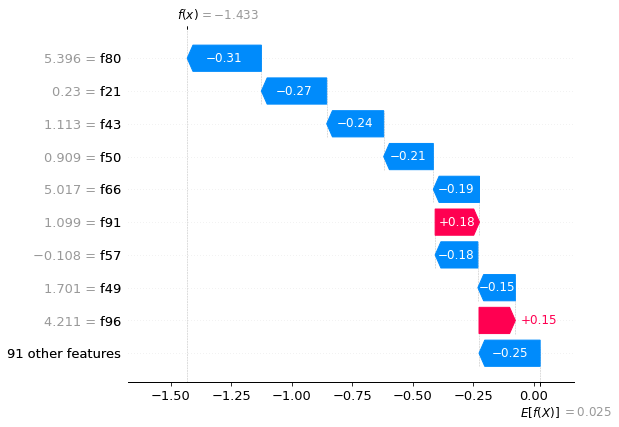

In [32]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

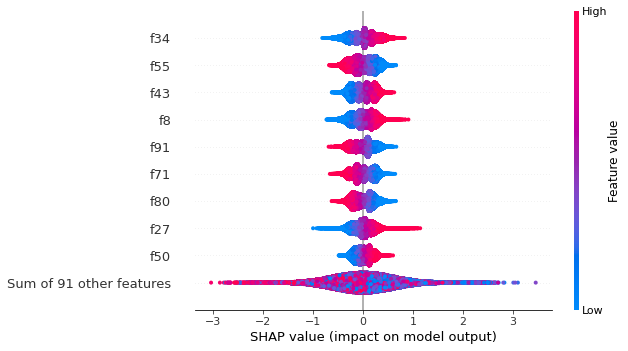

In [33]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

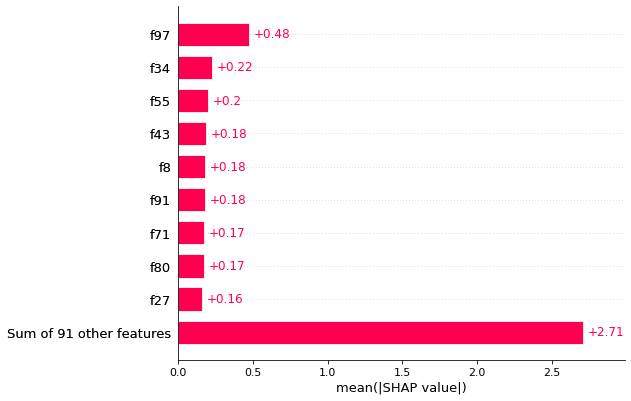

In [34]:
shap.plots.bar(shap_values)

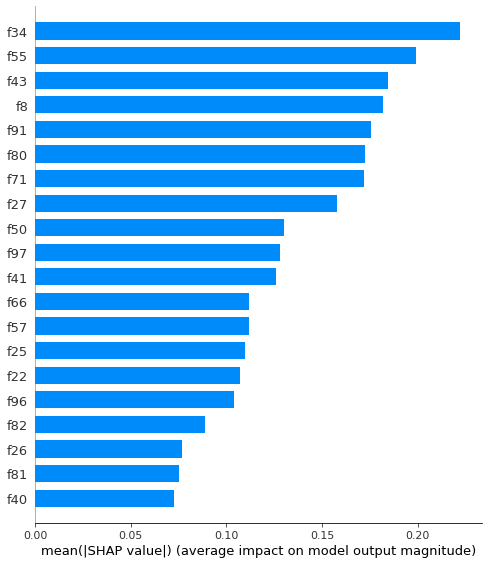

In [35]:
shap_values2 = explainer.shap_values(X_test)
shap.summary_plot(shap_values2, X_test, plot_type="bar")


In [36]:
#features_shap_df = feature_values_df.mean().sort_values(ascending = False).head(20).reset_index()
features_shap_df = feature_values_df.mean().sort_values(ascending = False).reset_index()
features_shap_df.rename(columns={'index':'feature'}, inplace=True)
features_shap_df['feature']


0     f97
1     f27
2     f41
3     f91
4     f82
5     f81
6     f44
7     f80
8     f24
9      f4
10    f51
11    f20
12    f10
13    f43
14    f26
15    f98
16    f55
17    f66
18    f30
19     f5
20    f56
21     f3
22    f93
23    f19
24    f60
25    f92
26    f17
27    f11
28    f40
29    f96
30    f67
31    f46
32    f45
33    f94
34    f70
35    f88
36    f37
37    f90
38     f2
39    f63
40    f15
41    f42
42    f73
43    f18
44    f59
45     f7
46    f62
47    f38
48    f58
49    f14
50    f32
51    f69
52     f6
53    f12
54    f77
55    f79
56    f52
57    f47
58    f28
59    f25
60    f57
61    f33
62    f53
63    f99
64    f13
65     f0
66    f49
67    f72
68    f89
69    f54
70    f85
71    f74
72    f35
73    f87
74    f68
75    f61
76     f8
77    f50
78    f75
79    f64
80    f34
81    f86
82    f76
83    f23
84    f83
85    f31
86    f36
87    f95
88    f21
89    f65
90    f29
91     f9
92    f39
93     f1
94    f78
95    f22
96    f48
97    f84
98    f71
99    f16


In [39]:
# Save
# filename = f'features_selected_shap_{selected_features_no}.csv'
filename = "important_features_sorted_shap_all.csv"
features_shap_df["feature"].to_csv(PATH_DATA_INT + filename, index=False)
